<a href="https://colab.research.google.com/github/YushkevichNV/DNN_and_CNN/blob/main/dense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h3 style="text-align: center;"><b>Полносвязные и свёрточные нейронные сети</b></h3>

Построение нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import math 

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

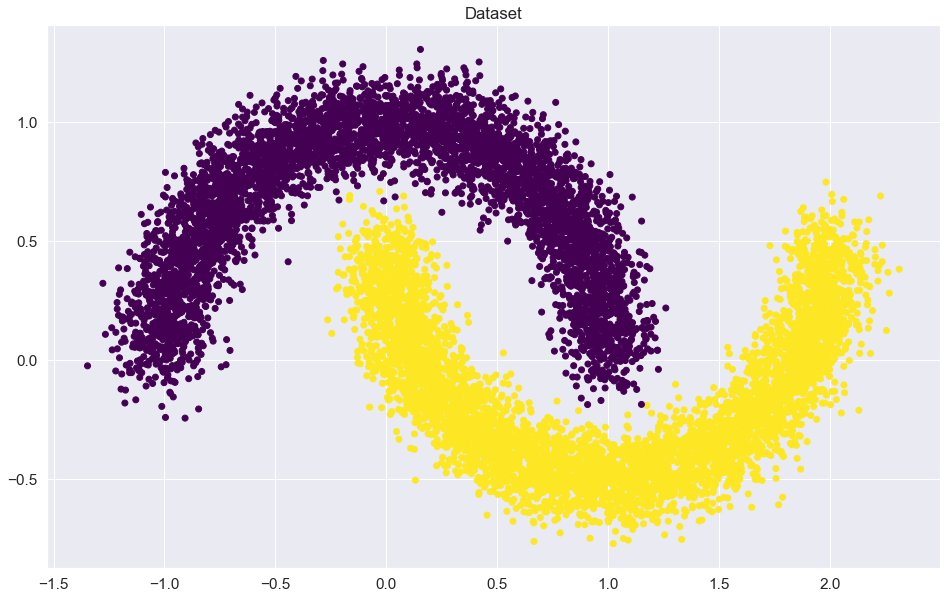

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

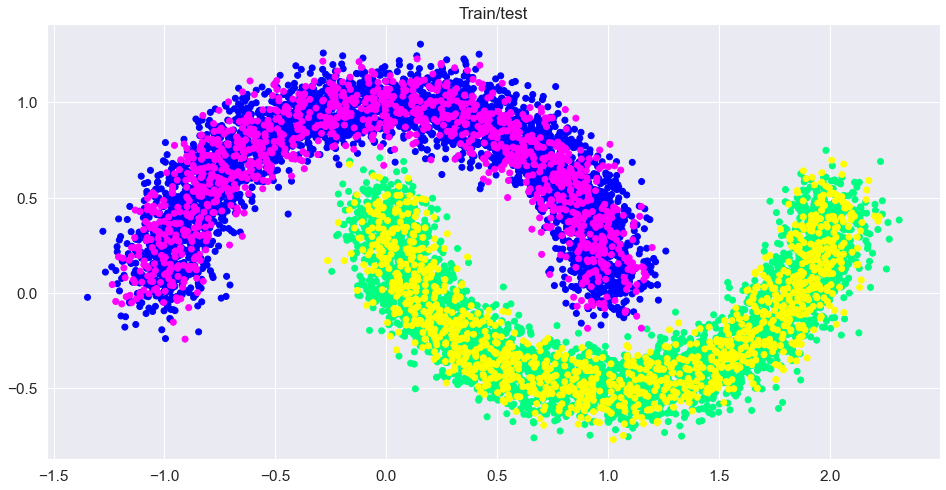

In [ ]:
plt.figure(figsize=(16, 8))
plt.title("Train/test")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="winter")
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap="spring")
plt.show()

### Загрузка данных


In [ ]:
X_train_t =  torch.tensor(X_train).type(torch.float32)
y_train_t =  torch.tensor(y_train).type(torch.float32)
X_val_t =  torch.tensor(X_val).type(torch.float32)
y_val_t =  torch.tensor(y_val).type(torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Реализация логистической регрессии

 $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. 


Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear`.

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad = True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.empty(out_features))
            k = 1 / math.sqrt(in_features) if in_features > 0 else 0
            nn.init.uniform_(self.bias_term, -k, k)
            

    def forward(self, x):
        x = x@self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

### Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(torch.squeeze(outp), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  1/(1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            num_iterations = it + epoch * len(train_dataloader)
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8515625
Iteration: 100
Batch accuracy: 0.890625
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.921875
Iteration: 400
Batch accuracy: 0.8984375

Iteration: 460.Convergence. Stopping iterations.


### Визуализируем результаты

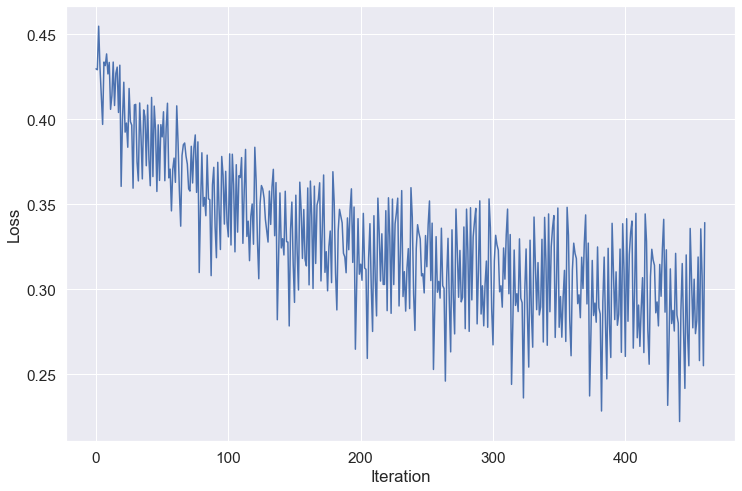

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

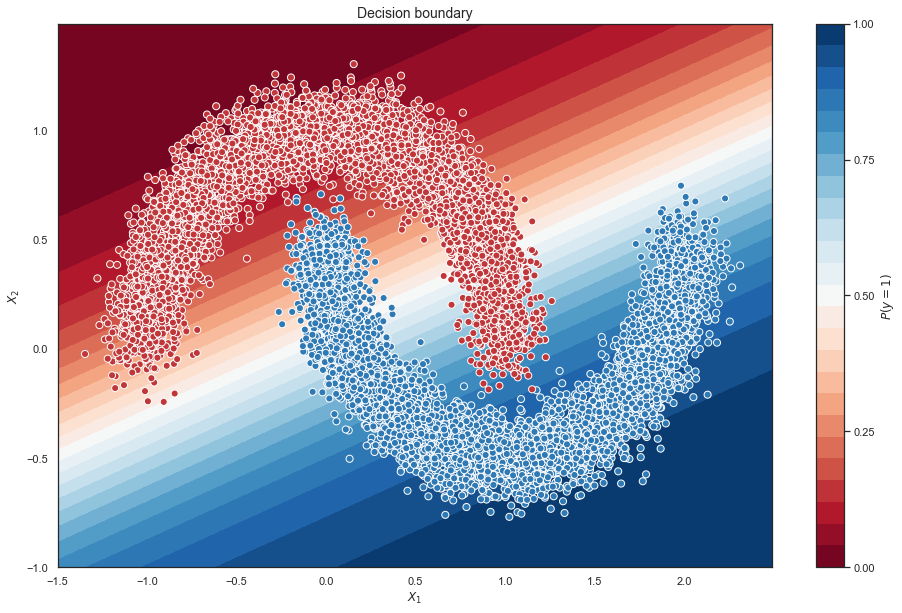

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)

### Реализация predict и подсчёт accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outs = model(x_batch)
        sigm_preds = 1/(1 + torch.exp(-outs))
        preds = (sigm_preds > 0.5).int().view(-1)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return torch.tensor(predictions.flatten()).type(torch.float32)

In [ ]:
y_pred = predict(val_dataloader, linear_regression)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t, y_pred)

0.8796

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. 

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Простая полносвязная нейронная сеть 

Создадим полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Важно задать лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU

model = nn.Sequential( 
    nn.Flatten(), 
    nn.Linear(784, 128), 
    activation(), 
    nn.Linear(128, 128), 
    activation(), 
    nn.Linear(128, 128), 
    activation(), 
    nn.Linear(128, 10) 
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = preds[preds == y_batch]
            all = len(y_batch)
            epoch_correct += correct.count_nonzero()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8068000078201294
Loader: valid. Accuracy: 0.8140000104904175
Epoch: 2
Loader: train. Accuracy: 0.8487666845321655
Loader: valid. Accuracy: 0.8464999794960022
Epoch: 3
Loader: train. Accuracy: 0.8570166826248169
Loader: valid. Accuracy: 0.8676000237464905
Epoch: 4
Loader: train. Accuracy: 0.8615166544914246
Loader: valid. Accuracy: 0.8621000051498413
Epoch: 5
Loader: train. Accuracy: 0.8634666800498962
Loader: valid. Accuracy: 0.8482000231742859
Epoch: 6
Loader: train. Accuracy: 0.8668000102043152
Loader: valid. Accuracy: 0.8528000116348267
Epoch: 7
Loader: train. Accuracy: 0.8685833215713501
Loader: valid. Accuracy: 0.8676999807357788
Epoch: 8
Loader: train. Accuracy: 0.8697999715805054
Loader: valid. Accuracy: 0.8569999933242798
Epoch: 9
Loader: train. Accuracy: 0.8711333274841309
Loader: valid. Accuracy: 0.8647000193595886
Epoch: 10
Loader: train. Accuracy: 0.8730833530426025
Loader: valid. Accuracy: 0.8507999777793884


## Часть 2.2 Сверточные нейронные сети

### Реализация LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. 
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        
        x = x.view(-1, 5 * 5 * 16) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучение CNN
Используем код обучения, который мы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = preds[preds == y_batch]
            all = len(y_batch)
            epoch_correct += correct.count_nonzero()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8597166538238525
Loader: valid. Accuracy: 0.8819999694824219
Epoch: 2
Loader: train. Accuracy: 0.8834666609764099
Loader: valid. Accuracy: 0.8835999965667725
Epoch: 3
Loader: train. Accuracy: 0.8879166841506958
Loader: valid. Accuracy: 0.8873999714851379
Epoch: 4
Loader: train. Accuracy: 0.8912500143051147
Loader: valid. Accuracy: 0.8901000022888184
Epoch: 5
Loader: train. Accuracy: 0.8918333649635315
Loader: valid. Accuracy: 0.8905999660491943
Epoch: 6
Loader: train. Accuracy: 0.8937000036239624
Loader: valid. Accuracy: 0.8913999795913696
Epoch: 7
Loader: train. Accuracy: 0.894016683101654
Loader: valid. Accuracy: 0.8801999688148499
Epoch: 8
Loader: train. Accuracy: 0.8945833444595337
Loader: valid. Accuracy: 0.8910999894142151
Epoch: 9
Loader: train. Accuracy: 0.8950833678245544
Loader: valid. Accuracy: 0.8899999856948853
Epoch: 10
Loader: train. Accuracy: 0.8956833481788635
Loader: valid. Accuracy: 0.887999951839447


In [ ]:
lenet_accuracy = accuracy["valid"]

In [ ]:
lenet_accuracy = list(map(torch.Tensor.cpu, lenet_accuracy))

Сравним с предыдущем пунктом

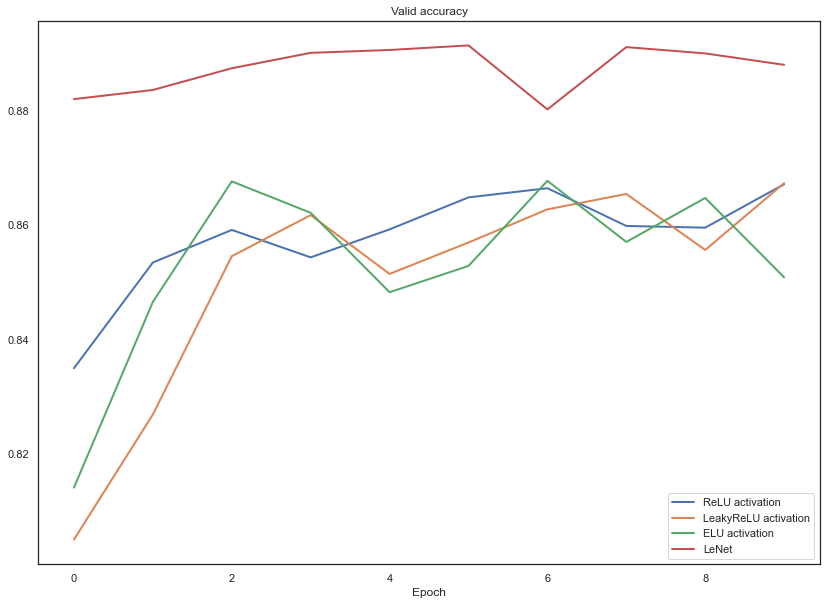

In [ ]:
plt.figure(figsize=(14, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()